In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_pairs
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, backend as K


2025-07-22 17:21:23.338976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-22 17:21:23.339051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-22 17:21:23.340419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 17:21:23.350010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 17:21:25.572278: W tensorflow/compiler/tf2

In [2]:
# Load LFW pairs
lfw_train = fetch_lfw_pairs(subset='train', color=True, resize=0.5)
lfw_test = fetch_lfw_pairs(subset='test', color=True, resize=0.5)
input_shape = lfw_train.pairs.shape[2:]


In [3]:
def get_base_model(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    return models.Model(inputs=inp, outputs=x)
base_model = get_base_model(input_shape)


2025-07-22 17:21:53.372202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-22 17:21:53.583800: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
feat_a = base_model(input_a)
feat_b = base_model(input_b)
concat = layers.concatenate([feat_a, feat_b])
output_bce = layers.Dense(1, activation='sigmoid')(concat)
model_bce = Model(inputs=[input_a, input_b], outputs=output_bce)
model_bce.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [5]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    squared_pred = K.square(y_pred)
    margin_squared = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * squared_pred + (1 - y_true) * margin_squared)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

input_a2 = Input(shape=input_shape)
input_b2 = Input(shape=input_shape)
feat_a2 = base_model(input_a2)
feat_b2 = base_model(input_b2)
distance = layers.Lambda(euclidean_distance)([feat_a2, feat_b2])
model_contrastive = Model([input_a2, input_b2], distance)
model_contrastive.compile(loss=contrastive_loss, optimizer='adam')


In [6]:
def triplet_loss(alpha=0.2):
    def loss(y_true, y_pred):
        total_len = y_pred.shape.as_list()[-1]
        anchor = y_pred[:,0:total_len//3]
        positive = y_pred[:,total_len//3:2*total_len//3]
        negative = y_pred[:,2*total_len//3:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        return K.mean(K.maximum(pos_dist - neg_dist + alpha, 0.0))
    return loss

anchor_in = Input(shape=input_shape)
pos_in = Input(shape=input_shape)
neg_in = Input(shape=input_shape)
anchor_feat = base_model(anchor_in)
pos_feat = base_model(pos_in)
neg_feat = base_model(neg_in)
merged = layers.concatenate([anchor_feat, pos_feat, neg_feat], axis=1)
model_triplet = Model([anchor_in, pos_in, neg_in], merged)
model_triplet.compile(loss=triplet_loss(), optimizer='adam')


In [7]:
X_a, X_b = lfw_train.pairs[:,0], lfw_train.pairs[:,1]
y_pairs = lfw_train.target
# Test data
X_a_test, X_b_test = lfw_test.pairs[:,0], lfw_test.pairs[:,1]
y_test = lfw_test.target


In [8]:
def get_triplets(pairs, labels, num_triplets=1000):
    anchors, positives, negatives = [], [], []
    idx_same = np.where(labels == 1)[0]
    idx_diff = np.where(labels == 0)[0]
    for _ in range(num_triplets):
        i = np.random.choice(idx_same)
        j = np.random.choice(idx_diff)
        anchors.append(pairs[i,0])
        positives.append(pairs[i,1])
        negatives.append(pairs[j,1])
    return np.array(anchors), np.array(positives), np.array(negatives)
anchors, positives, negatives = get_triplets(lfw_train.pairs, lfw_train.target, num_triplets=1500)


In [9]:
history_bce = model_bce.fit([X_a, X_b], y_pairs, batch_size=32, epochs=5, validation_split=0.2)
history_contrastive = model_contrastive.fit([X_a, X_b], y_pairs, batch_size=32, epochs=5, validation_split=0.2)
dummy_y_triplet = np.zeros((anchors.shape[0],))
history_triplet = model_triplet.fit([anchors, positives, negatives], dummy_y_triplet, batch_size=32, epochs=5, validation_split=0.2)


Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.6302 - loss: 0.6629 - val_accuracy: 0.0000e+00 - val_loss: 0.9856
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.6111 - loss: 0.6691 - val_accuracy: 0.0000e+00 - val_loss: 1.0259
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6323 - loss: 0.6583 - val_accuracy: 0.0000e+00 - val_loss: 0.9673
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.6236 - loss: 0.6625 - val_accuracy: 0.0000e+00 - val_loss: 0.9940
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.6334 - loss: 0.6573 - val_accuracy: 0.0000e+00 - val_loss: 0.9343
Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.2925 - val_loss: 0.4678
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.2383 - val_loss: 0.3514
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.2253 - val_loss: 0.4472
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.2266 - val_loss: 0.4424
E

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


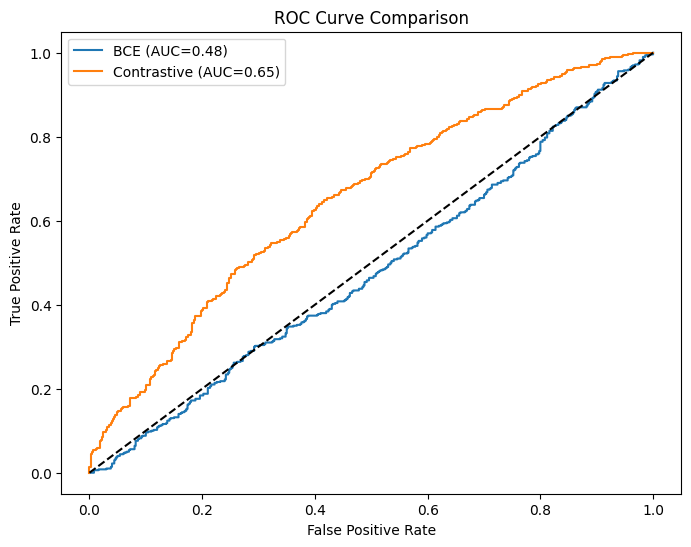

In [10]:
# BCE predictions
bce_preds = model_bce.predict([X_a_test, X_b_test])
fpr_bce, tpr_bce, _ = roc_curve(y_test, bce_preds)
auc_bce = auc(fpr_bce, tpr_bce)

# Contrastive predictions
embeddings_a = base_model.predict(X_a_test)
embeddings_b = base_model.predict(X_b_test)
l2_dist = np.linalg.norm(embeddings_a - embeddings_b, axis=1)
fpr_cont, tpr_cont, _ = roc_curve(y_test, -l2_dist)
auc_cont = auc(fpr_cont, tpr_cont)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr_bce, tpr_bce, label=f'BCE (AUC={auc_bce:.2f})')
plt.plot(fpr_cont, tpr_cont, label=f'Contrastive (AUC={auc_cont:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


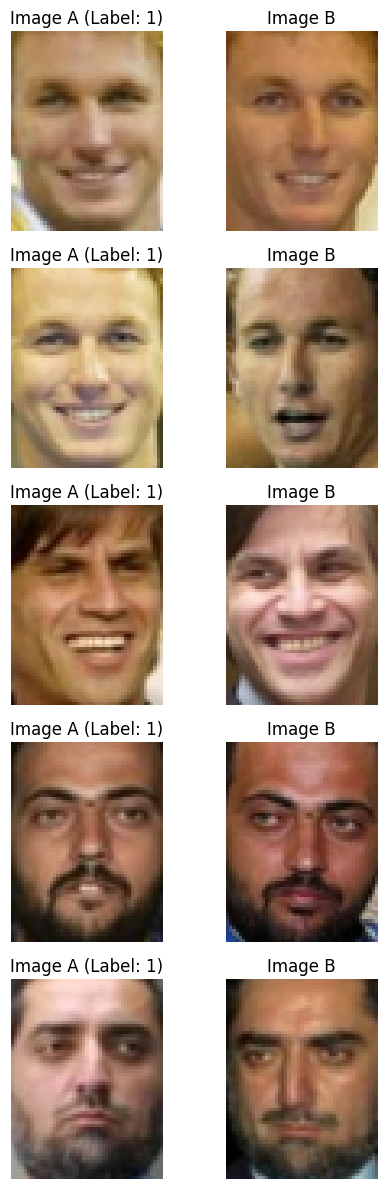

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_pairs

# Load a few pairs from LFW
lfw_pairs = fetch_lfw_pairs(subset='train', color=True, resize=0.5)
pairs = lfw_pairs.pairs[:5]
labels = lfw_pairs.target[:5]  # 1: same, 0: different

fig, axs = plt.subplots(5, 2, figsize=(5, 12))
for i in range(5):
    for j in range(2):
        axs[i, j].imshow(pairs[i, j])
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f'Image A (Label: {labels[i]})')
        else:
            axs[i, j].set_title('Image B')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
import random

# --- 1. Parameters ---
IMG_SIZE = (96, 96)  # resize for faster training
BATCH_SIZE = 32
EPOCHS = 5

# --- 2. Load paired images from folder ---
def load_images_from_path(path, img_size=IMG_SIZE):
    images = []
    files = sorted(list(path.glob('*')))  # sorted for matched pairs
    for f in files:
        img = load_img(f, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

left_imgs = load_images_from_path(Path("Data/left"))
right_imgs = load_images_from_path(Path("Data/right"))

print(f"Loaded left images: {left_imgs.shape}, right images: {right_imgs.shape}")

# For simplicity, create dummy labels: 
# Assuming all pairs in order are positive (1)
labels = np.ones(len(left_imgs))

# For triplet loss: generate simple negative samples by shuffling right images
right_imgs_neg = np.roll(right_imgs, shift=1, axis=0)  # shift by 1 to create negatives

# --- 3. Shared feature extractor ---
def create_base_network(input_shape):
    inp = Input(input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x)

input_shape = left_imgs.shape[1:]
base_network = create_base_network(input_shape)

# --- 4A. Model with Binary Cross-Entropy loss (BCE) ---
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
feat_a = base_network(input_a)
feat_b = base_network(input_b)
concat = layers.concatenate([feat_a, feat_b])
output_bce = layers.Dense(1, activation='sigmoid')(concat)
model_bce = Model([input_a, input_b], output_bce)
model_bce.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 4B. Model with Contrastive Loss ---
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

input_a2 = Input(shape=input_shape)
input_b2 = Input(shape=input_shape)
feat_a2 = base_network(input_a2)
feat_b2 = base_network(input_b2)
dist = layers.Lambda(euclidean_distance)([feat_a2, feat_b2])
model_contrastive = Model([input_a2, input_b2], dist)
model_contrastive.compile(optimizer='adam', loss=contrastive_loss(margin=1.0))

# --- 4C. Model with Triplet Loss ---
def triplet_loss(alpha=0.2):
    def loss(y_true, y_pred):
        anchor = y_pred[:, 0:128]
        pos = y_pred[:, 128:256]
        neg = y_pred[:, 256:384]
        pos_dist = K.sum(K.square(anchor - pos), axis=1)
        neg_dist = K.sum(K.square(anchor - neg), axis=1)
        basic_loss = pos_dist - neg_dist + alpha
        loss = K.maximum(basic_loss, 0.0)
        return K.mean(loss)
    return loss

input_anchor = Input(shape=input_shape)
input_pos = Input(shape=input_shape)
input_neg = Input(shape=input_shape)
feat_anchor = base_network(input_anchor)
feat_pos = base_network(input_pos)
feat_neg = base_network(input_neg)
merged_feat = layers.concatenate([feat_anchor, feat_pos, feat_neg])
model_triplet = Model([input_anchor, input_pos, input_neg], merged_feat)
model_triplet.compile(optimizer='adam', loss=triplet_loss(alpha=0.2))

# --- 5. Prepare dataset for triplet model ---
# anchor=left_imgs, positive=right_imgs (assume positive pairs)
# negative samples = shifted right imgs (simple negative samples)
anchor_train, positive_train, negative_train = left_imgs, right_imgs, right_imgs_neg
dummy_y = np.zeros(len(anchor_train))  # dummy labels for triplet loss

# --- 6. Train the models ---
print("Training BCE model...")
model_bce.fit([left_imgs, right_imgs], labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

print("Training Contrastive model...")
model_contrastive.fit([left_imgs, right_imgs], labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

print("Training Triplet model...")
model_triplet.fit([anchor_train, positive_train, negative_train], dummy_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

# --- 7. Visualization ---
def plot_image_pairs(images1, images2, labels, preds_bce=None, preds_contrastive=None, preds_triplet=None, num=5):
    plt.figure(figsize=(12, 3*num))
    for i in range(num):
        ax1 = plt.subplot(num, 2, 2*i+1)
        plt.imshow(images1[i])
        plt.axis('off')
        plt.title(f'Anchor\nLabel: {labels[i]}')
        ax2 = plt.subplot(num, 2, 2*i+2)
        plt.imshow(images2[i])
        plt.axis('off')
        titles = []
        if preds_bce is not None:
            titles.append(f'BCE: {preds_bce[i]:.2f}')
        if preds_contrastive is not None:
            titles.append(f'Contrastive Dist: {preds_contrastive[i]:.2f}')
        if preds_triplet is not None:
            titles.append(f'Triplet Score: {preds_triplet[i]:.2f}')
        plt.title('\n'.join(titles))
    plt.tight_layout()
    plt.show()

# --- 8. Predict on some samples to visualize ---
sample_idx = list(range(min(20, len(left_imgs))))

# BCE prediction (probability)
bce_preds = model_bce.predict([left_imgs[sample_idx], right_imgs[sample_idx]]).flatten()

# Contrastive distance prediction
contrastive_dists = model_contrastive.predict([left_imgs[sample_idx], right_imgs[sample_idx]]).flatten()

# Triplet score simplified: Euclidean distance between anchor and positive in embedding space
embed_anchor = base_network.predict(left_imgs[sample_idx])
embed_positive = base_network.predict(right_imgs[sample_idx])
triplet_scores = np.linalg.norm(embed_anchor - embed_positive, axis=1)

# Visualize 5 pairs with predictions
plot_image_pairs(left_imgs[sample_idx][:5], 
                 right_imgs[sample_idx][:5], 
                 labels[sample_idx][:5],
                 preds_bce=bce_preds[:5], 
                 preds_contrastive=contrastive_dists[:5], 
                 preds_triplet=triplet_scores[:5])


Loaded left images: (6016, 96, 96, 3), right images: (6016, 96, 96, 3)
Training BCE model...


2025-07-22 17:59:06.539523: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532168704 exceeds 10% of free system memory.
2025-07-22 17:59:08.267621: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532168704 exceeds 10% of free system memory.


Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9757 - loss: 0.2269

2025-07-22 18:00:06.917399: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 133152768 exceeds 10% of free system memory.
2025-07-22 18:00:07.255791: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 133152768 exceeds 10% of free system memory.


151/151 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.9758 - loss: 0.2263 - val_accuracy: 1.0000 - val_loss: 0.0643
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 213ms/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 0.0263
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 217ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0145
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0065
Training Contrastive model...


2025-07-22 18:02:19.311513: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532168704 exceeds 10% of free system memory.


: 

No GPU detected, running on CPU
Loaded left images: (6016, 96, 96, 3), right images: (6016, 96, 96, 3)
Training BCE model...
Epoch 1/2
151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9977 - loss: 0.2315 - val_accuracy: 1.0000 - val_loss: 0.0619
Epoch 2/2
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 1.0000 - loss: 0.0486 - val_accuracy: 1.0000 - val_loss: 0.0244
Training Contrastive model...
Epoch 1/2
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - loss: 1.0527e-04 - val_loss: 2.2330e-06
Epoch 2/2
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - loss: 1.9597e-06 - val_loss: 1.7427e-06
Training Triplet model...
Epoch 1/2
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - loss: 0.1871 - val_loss: 0.1679
Epoch 2/2
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 298ms/step - loss: 0.1648 - val_loss: 0.1468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Visualizing BCE and Contrastive pairs...


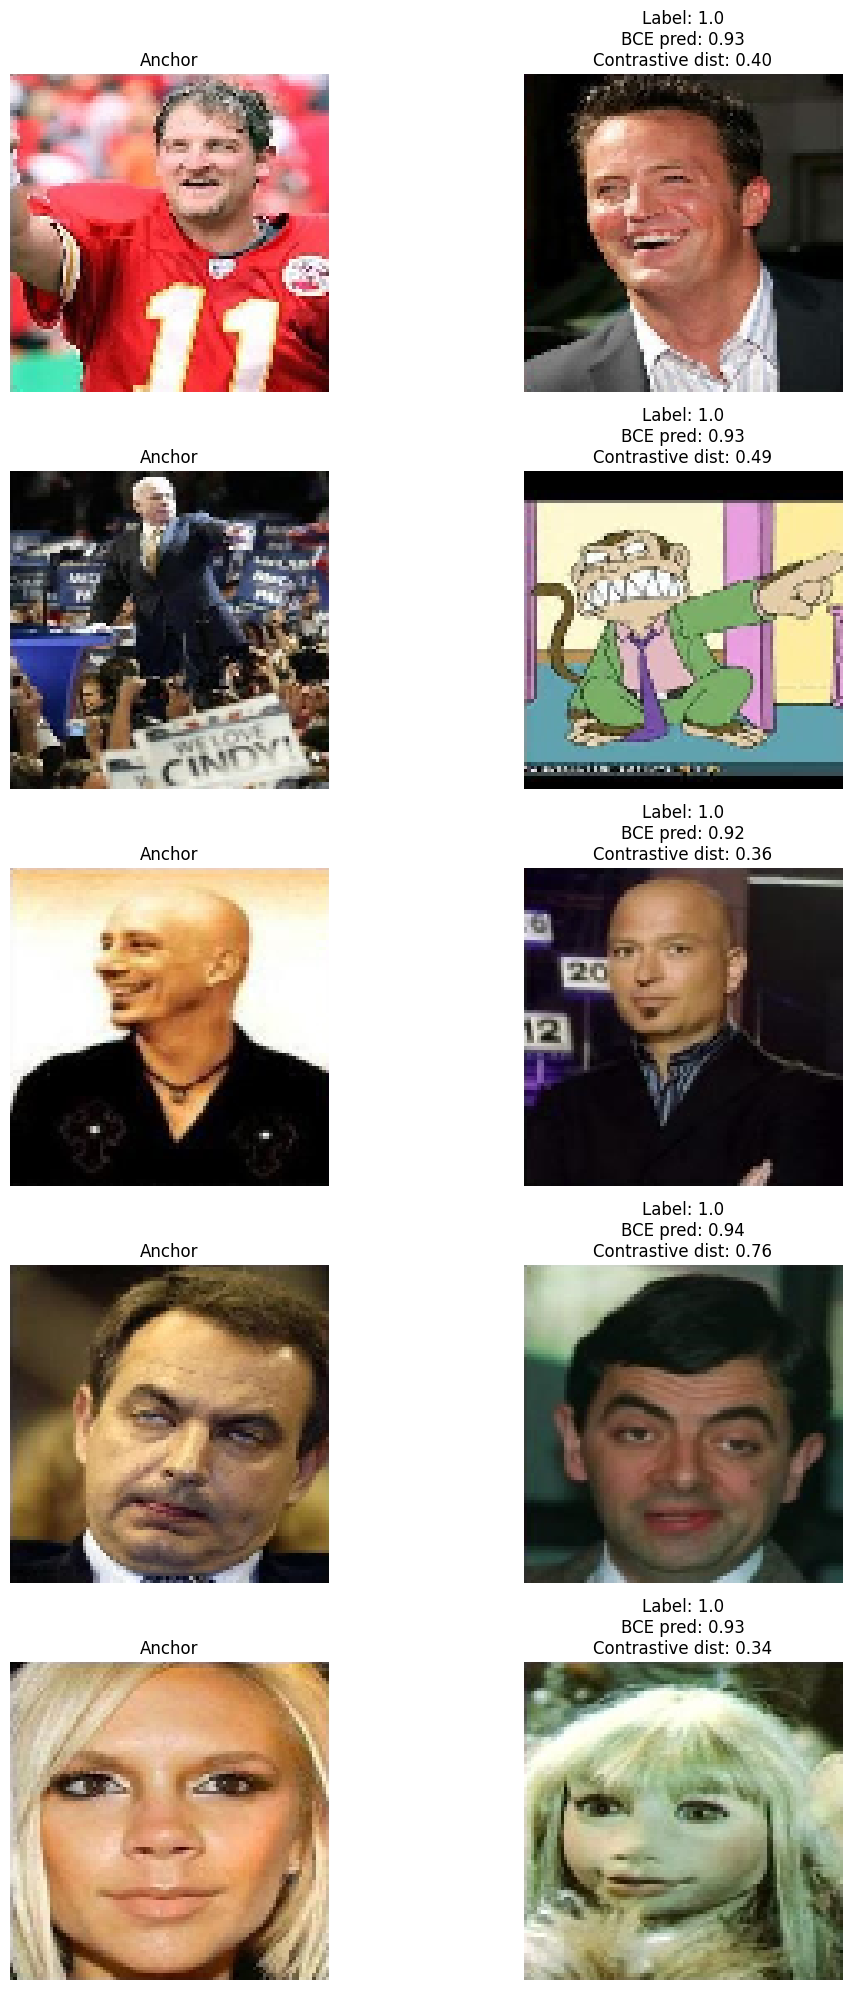

Visualizing Triplet samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


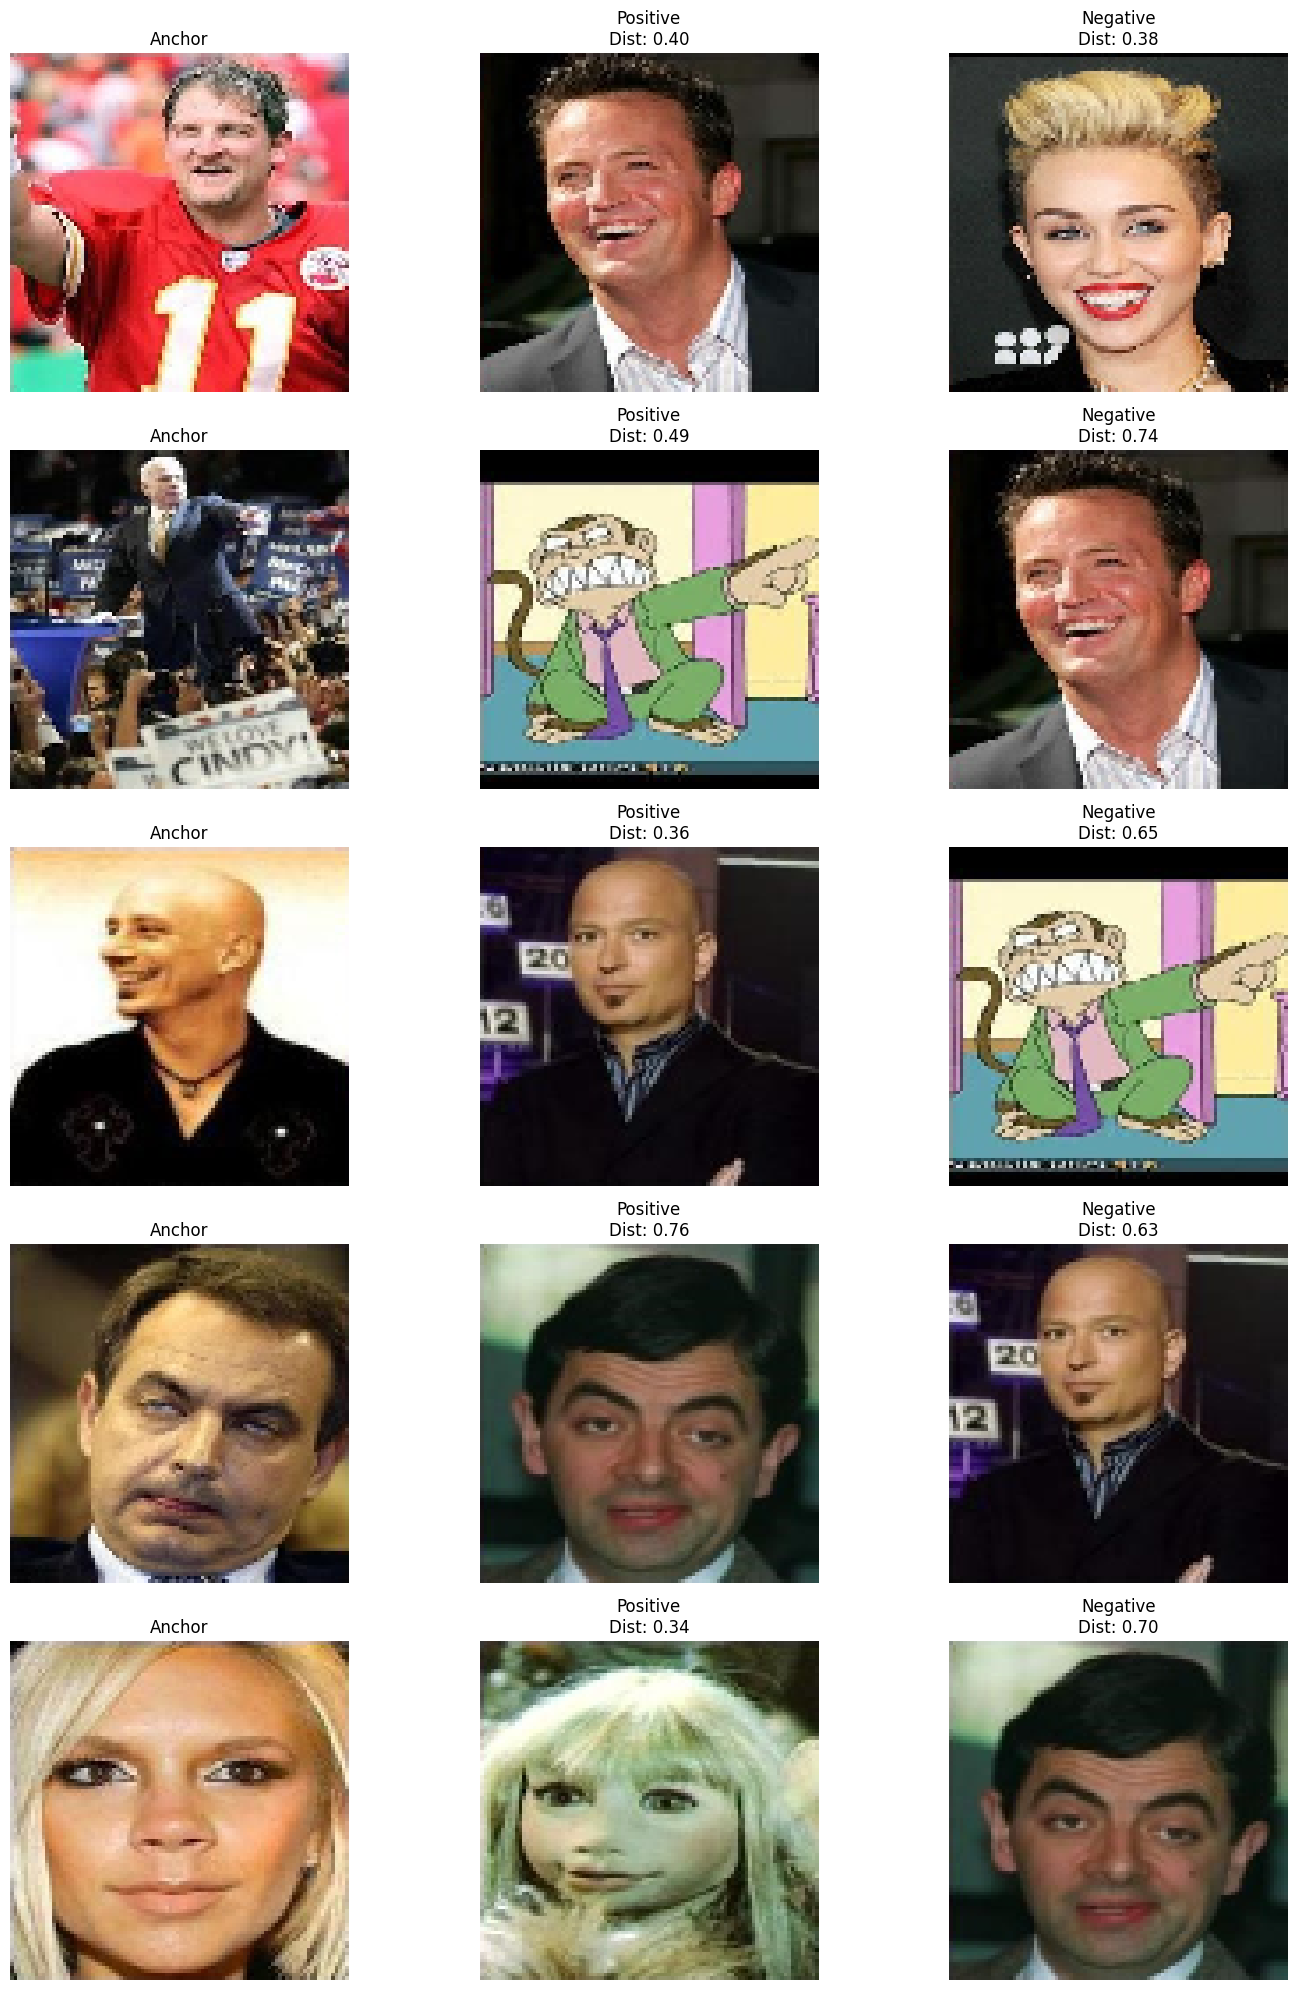

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- GPU memory growth setup (put at very top) ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth on {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected, running on CPU")

# --- 1. Parameters ---
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 2

# --- 2. Load paired images from folders ---
def load_images_from_path(path, img_size=IMG_SIZE):
    images = []
    files = sorted(list(path.glob('*')))
    for f in files:
        img = load_img(f, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

left_imgs = load_images_from_path(Path("Data/left"))
right_imgs = load_images_from_path(Path("Data/right"))
print(f"Loaded left images: {left_imgs.shape}, right images: {right_imgs.shape}")

# Labels for pairs: assume all are positive pairs (1)
labels = np.ones(len(left_imgs))

# For triplet loss: negatives = right images shifted by 1 (simple heuristic)
right_imgs_neg = np.roll(right_imgs, shift=1, axis=0)

# --- 3. Shared feature extractor network ---
def create_base_network(input_shape):
    inp = Input(input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x)

input_shape = left_imgs.shape[1:]
base_network = create_base_network(input_shape)

# --- 4A. Binary Cross-Entropy Model ---
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
feat_a = base_network(input_a)
feat_b = base_network(input_b)
concat = layers.concatenate([feat_a, feat_b])
output_bce = layers.Dense(1, activation='sigmoid')(concat)
model_bce = Model([input_a, input_b], output_bce)
model_bce.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 4B. Contrastive Loss ---

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

input_a2 = Input(shape=input_shape)
input_b2 = Input(shape=input_shape)
feat_a2 = base_network(input_a2)
feat_b2 = base_network(input_b2)
dist = layers.Lambda(euclidean_distance)([feat_a2, feat_b2])
model_contrastive = Model([input_a2, input_b2], dist)
model_contrastive.compile(optimizer='adam', loss=contrastive_loss(margin=1))

# --- 4C. Triplet Loss Model ---
def triplet_loss(alpha=0.2):
    def loss(y_true, y_pred):
        anchor = y_pred[:, 0:128]
        positive = y_pred[:, 128:256]
        negative = y_pred[:, 256:384]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + alpha
        return K.mean(K.maximum(basic_loss, 0.0))
    return loss

input_anchor = Input(shape=input_shape)
input_pos = Input(shape=input_shape)
input_neg = Input(shape=input_shape)
feat_anchor = base_network(input_anchor)
feat_pos = base_network(input_pos)
feat_neg = base_network(input_neg)
merged_feat = layers.concatenate([feat_anchor, feat_pos, feat_neg])
model_triplet = Model([input_anchor, input_pos, input_neg], merged_feat)
model_triplet.compile(optimizer='adam', loss=triplet_loss(alpha=0.2))

# --- 5. Prepare triplet data ---
anchor_train, positive_train, negative_train = left_imgs, right_imgs, right_imgs_neg
dummy_y = np.zeros(len(anchor_train))

# --- 6. Train Models ---

print("Training BCE model...")
model_bce.fit([left_imgs, right_imgs], labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

print("Training Contrastive model...")
model_contrastive.fit([left_imgs, right_imgs], labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

print("Training Triplet model...")
model_triplet.fit([anchor_train, positive_train, negative_train], dummy_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

# --- 7. Prediction & Visualization ---
def plot_pairs(images1, images2, labels, preds_bce=None, preds_cont=None, num=5):
    plt.figure(figsize=(12, 4 * num))
    for i in range(num):
        plt.subplot(num, 2, 2*i+1)
        plt.imshow(images1[i])
        plt.axis('off')
        plt.title("Anchor")
        plt.subplot(num, 2, 2*i+2)
        plt.imshow(images2[i])
        title = f"Label: {labels[i]}"
        if preds_bce is not None:
            title += f"\nBCE pred: {preds_bce[i]:.2f}"
        if preds_cont is not None:
            title += f"\nContrastive dist: {preds_cont[i]:.2f}"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_triplets(anchor, positive, negative, base_net, num=5):
    emb_anchor = base_net.predict(anchor)
    emb_pos = base_net.predict(positive)
    emb_neg = base_net.predict(negative)
    dist_pos = np.linalg.norm(emb_anchor - emb_pos, axis=1)
    dist_neg = np.linalg.norm(emb_anchor - emb_neg, axis=1)
    plt.figure(figsize=(15, 4 * num))
    for i in range(num):
        plt.subplot(num, 3, 3*i+1)
        plt.imshow(anchor[i])
        plt.title("Anchor")
        plt.axis('off')
        plt.subplot(num, 3, 3*i+2)
        plt.imshow(positive[i])
        plt.title(f"Positive\nDist: {dist_pos[i]:.2f}")
        plt.axis('off')
        plt.subplot(num, 3, 3*i+3)
        plt.imshow(negative[i])
        plt.title(f"Negative\nDist: {dist_neg[i]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

sample_num = min(20, len(left_imgs))
# BCE predictions
preds_bce = model_bce.predict([left_imgs[:sample_num], right_imgs[:sample_num]]).flatten()
# Contrastive distances
preds_cont = model_contrastive.predict([left_imgs[:sample_num], right_imgs[:sample_num]]).flatten()

print("Visualizing BCE and Contrastive pairs...")
plot_pairs(left_imgs[:sample_num], right_imgs[:sample_num], labels[:sample_num], preds_bce=preds_bce, preds_cont=preds_cont)

print("Visualizing Triplet samples...")
plot_triplets(anchor_train[:sample_num], positive_train[:sample_num], negative_train[:sample_num], base_network, num=5)
